# Digit Recognizer (MNIST Data)

This notebook is heavily based on Jeremy Howard's notebooks from Practical Deep Learning For Coders, Part 1 (course.fast.ai). Download the competitions files into data/mnist folder.

Kaggle Competition: https://www.kaggle.com/c/digit-recognizer

Score: 0.994

## Imports

In [1]:
from theano.sandbox import cuda
cuda.use('gpu2')

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using TensorFlow backend.


## Setup

In [4]:
path="data/mnist/"
model_path = path + 'models/'
results_path = path + 'results/'
submissions_path = path + 'submissions/'
if not os.path.exists(model_path): os.mkdir(model_path)
if not os.path.exists(results_path): os.mkdir(results_path)
if not os.path.exists(submissions_path): os.mkdir(submissions_path)
batch_size=64

## Reading Data

In [7]:
training = pd.read_csv(path+'train.csv')
training.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
test = pd.read_csv(path+"test.csv")
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Normalize

In [8]:
Y_train = training['label'].values

In [9]:
Y_train

array([1, 0, 1, ..., 7, 6, 9])

In [10]:
X_train = training.iloc[:,1:].values
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) #reshape to rectangular
X_train = X_train/255 #pixel values are 0 - 255 - this makes puts them in the range 0 - 1

In [11]:
X_val = X_train[32000:]

In [12]:
X_train = X_train[0:32000]

In [13]:
Y_val = Y_train[32000:]
Y_train = Y_train[0:32000]

In [15]:
X_test = test.iloc[:,0:].values
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1) #reshape to rectangular
X_test = X_test/255 #pixel values are 0 - 255 - this makes puts them in the range 0 - 1

In [16]:
(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

((32000, 28, 28, 1), (32000,), (10000, 28, 28, 1), (10000,))

To match the axis that theano expects (channel on axis 1)

In [17]:
X_train = np.expand_dims(X_train,1)
X_val = np.expand_dims(X_val,1)

In [18]:
X_train = np.squeeze(X_train,4)
X_val = np.squeeze(X_val,4)

In [19]:
(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

((32000, 1, 28, 28), (32000,), (10000, 1, 28, 28), (10000,))

As expected from theano

In [20]:
Y_train = onehot(Y_train)
Y_val = onehot(Y_val)

In [21]:
Y_train[:5]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [22]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

In [23]:
def norm_input(x): return (x-mean_px)/std_px

## A look at the data

In [39]:
def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')
    
plt.gray()
plt.close()

In [30]:
digits = np.squeeze(X_train, 1)

In [31]:
digits.shape

(32000, 28, 28)

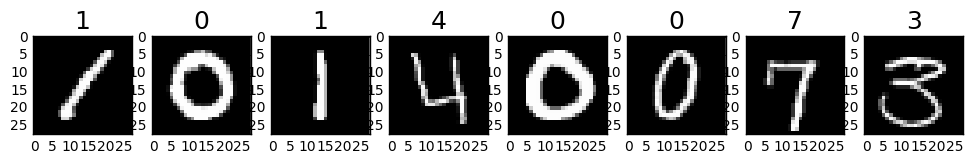

In [44]:
plots(digits[0:8], titles=Y_train.argmax(axis=1)[0:8])

## Batchnorm + dropout + data augmentation

In [27]:
def get_model_bn_do():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28)),
        Convolution2D(32,3,3, activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(32,3,3, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(64,3,3, activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,3,3, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Ensembling

In [34]:
def fit_model():
    model = get_model_bn_do()
    model.fit_generator(batches, batches.N, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.N)
    model.optimizer.lr=0.1
    model.fit_generator(batches, batches.N, nb_epoch=4,
                    validation_data=val_batches, nb_val_samples=val_batches.N)
    model.optimizer.lr=0.01
    model.fit_generator(batches, batches.N, nb_epoch=12,
                    validation_data=val_batches, nb_val_samples=val_batches.N)
    model.optimizer.lr=0.001
    model.fit_generator(batches, batches.N, nb_epoch=18,
                    validation_data=val_batches, nb_val_samples=val_batches.N)
    return model

In [35]:
models = [fit_model() for i in range(6)]

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_5 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Epoch 1/1
32000/32000 [==============================] - 22s - loss: 0.1446 - acc: 0.9568 - val_loss: 0.0754 - val_acc: 0.9777
Epoch 1/4
32000/32000 [==============================] - 22s - loss: 0.0520 - acc: 0.9837 - val_loss: 0.0434 - val_acc: 0.9877
Epoch 2/4
32000/32000 [==============================] - 22s - loss: 0.0317 - acc: 0.9900 - val_loss: 0.0478 - val_acc: 0.9870
Epoch 3/4
32000/32000 [==============================] - 21s - loss: 0.0267 - acc: 0.9914 - val_loss: 0.0348 - val_acc: 0.9903
Epoch 4/4
32000/32000 [==============================] - 21s - loss: 0.0251 - acc: 0.9916 - val_loss: 0.0422 - val_acc: 0.9894
Epoch 1/12
32000/32000 [==============================] - 22s - loss: 0.0182 - acc: 0.9937 - val_loss: 0.0454 - val_acc: 0.9877
Epoch 2/12
32000/32000 [==============================] - 22s - loss: 0.0198 - acc: 0.9933 - val_loss: 0.0423 - val_acc: 0.9894
Epoch 3/12
32000/32000 [==============================] - 21s - loss: 0.0168 - acc: 0.9942 - val_loss: 0.0352

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_6 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Epoch 1/1
32000/32000 [==============================] - 21s - loss: 0.1448 - acc: 0.9562 - val_loss: 0.0645 - val_acc: 0.9804
Epoch 1/4
32000/32000 [==============================] - 22s - loss: 0.0503 - acc: 0.9840 - val_loss: 0.0421 - val_acc: 0.9876
Epoch 2/4
32000/32000 [==============================] - 22s - loss: 0.0346 - acc: 0.9888 - val_loss: 0.0432 - val_acc: 0.9885
Epoch 3/4
32000/32000 [==============================] - 22s - loss: 0.0219 - acc: 0.9933 - val_loss: 0.0452 - val_acc: 0.9881
Epoch 4/4
32000/32000 [==============================] - 22s - loss: 0.0228 - acc: 0.9929 - val_loss: 0.0429 - val_acc: 0.9888
Epoch 1/12
32000/32000 [==============================] - 22s - loss: 0.0199 - acc: 0.9935 - val_loss: 0.0437 - val_acc: 0.9901
Epoch 2/12
32000/32000 [==============================] - 22s - loss: 0.0171 - acc: 0.9944 - val_loss: 0.0498 - val_acc: 0.9877
Epoch 3/12
32000/32000 [==============================] - 22s - loss: 0.0157 - acc: 0.9952 - val_loss: 0.0420

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_7 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Epoch 1/1
32000/32000 [==============================] - 22s - loss: 0.1554 - acc: 0.9539 - val_loss: 0.0837 - val_acc: 0.9740
Epoch 1/4
32000/32000 [==============================] - 22s - loss: 0.0494 - acc: 0.9850 - val_loss: 0.0689 - val_acc: 0.9802
Epoch 2/4
32000/32000 [==============================] - 22s - loss: 0.0344 - acc: 0.9888 - val_loss: 0.0379 - val_acc: 0.9884
Epoch 3/4
32000/32000 [==============================] - 21s - loss: 0.0257 - acc: 0.9914 - val_loss: 0.0424 - val_acc: 0.9884
Epoch 4/4
32000/32000 [==============================] - 21s - loss: 0.0239 - acc: 0.9924 - val_loss: 0.0508 - val_acc: 0.9875
Epoch 1/12
32000/32000 [==============================] - 22s - loss: 0.0188 - acc: 0.9935 - val_loss: 0.0353 - val_acc: 0.9907
Epoch 2/12
32000/32000 [==============================] - 21s - loss: 0.0145 - acc: 0.9952 - val_loss: 0.0520 - val_acc: 0.9856
Epoch 3/12
32000/32000 [==============================] - 22s - loss: 0.0193 - acc: 0.9940 - val_loss: 0.0477

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_8 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Epoch 1/1
32000/32000 [==============================] - 22s - loss: 0.1457 - acc: 0.9561 - val_loss: 0.0952 - val_acc: 0.9712
Epoch 1/4
32000/32000 [==============================] - 22s - loss: 0.0516 - acc: 0.9839 - val_loss: 0.0349 - val_acc: 0.9886
Epoch 2/4
32000/32000 [==============================] - 22s - loss: 0.0339 - acc: 0.9890 - val_loss: 0.0358 - val_acc: 0.9906
Epoch 3/4
32000/32000 [==============================] - 22s - loss: 0.0238 - acc: 0.9923 - val_loss: 0.0423 - val_acc: 0.9871
Epoch 4/4
32000/32000 [==============================] - 22s - loss: 0.0215 - acc: 0.9930 - val_loss: 0.0513 - val_acc: 0.9884
Epoch 1/12
32000/32000 [==============================] - 21s - loss: 0.0221 - acc: 0.9928 - val_loss: 0.0328 - val_acc: 0.9923
Epoch 2/12
32000/32000 [==============================] - 22s - loss: 0.0167 - acc: 0.9942 - val_loss: 0.0376 - val_acc: 0.9906
Epoch 3/12
32000/32000 [==============================] - 22s - loss: 0.0184 - acc: 0.9937 - val_loss: 0.0467

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_9 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Epoch 1/1
32000/32000 [==============================] - 21s - loss: 0.1571 - acc: 0.9545 - val_loss: 0.0560 - val_acc: 0.9829
Epoch 1/4
32000/32000 [==============================] - 22s - loss: 0.0519 - acc: 0.9843 - val_loss: 0.0498 - val_acc: 0.9862
Epoch 2/4
32000/32000 [==============================] - 22s - loss: 0.0333 - acc: 0.9895 - val_loss: 0.0548 - val_acc: 0.9837
Epoch 3/4
32000/32000 [==============================] - 22s - loss: 0.0269 - acc: 0.9915 - val_loss: 0.0483 - val_acc: 0.9867
Epoch 4/4
32000/32000 [==============================] - 22s - loss: 0.0205 - acc: 0.9929 - val_loss: 0.0464 - val_acc: 0.9865
Epoch 1/12
32000/32000 [==============================] - 22s - loss: 0.0196 - acc: 0.9938 - val_loss: 0.0342 - val_acc: 0.9905
Epoch 2/12
32000/32000 [==============================] - 22s - loss: 0.0175 - acc: 0.9947 - val_loss: 0.0366 - val_acc: 0.9914
Epoch 3/12
32000/32000 [==============================] - 22s - loss: 0.0164 - acc: 0.9945 - val_loss: 0.0629

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_10 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Epoch 1/1
32000/32000 [==============================] - 22s - loss: 0.1450 - acc: 0.9573 - val_loss: 0.1118 - val_acc: 0.9703
Epoch 1/4
32000/32000 [==============================] - 22s - loss: 0.0527 - acc: 0.9833 - val_loss: 0.0408 - val_acc: 0.9892
Epoch 2/4
32000/32000 [==============================] - 22s - loss: 0.0353 - acc: 0.9885 - val_loss: 0.0305 - val_acc: 0.9904
Epoch 3/4
32000/32000 [==============================] - 22s - loss: 0.0247 - acc: 0.9916 - val_loss: 0.0520 - val_acc: 0.9865
Epoch 4/4
32000/32000 [==============================] - 22s - loss: 0.0239 - acc: 0.9921 - val_loss: 0.0491 - val_acc: 0.9868
Epoch 1/12
32000/32000 [==============================] - 22s - loss: 0.0207 - acc: 0.9933 - val_loss: 0.0311 - val_acc: 0.9925
Epoch 2/12
32000/32000 [==============================] - 22s - loss: 0.0177 - acc: 0.9937 - val_loss: 0.0450 - val_acc: 0.9886
Epoch 3/12
32000/32000 [==============================] - 22s - loss: 0.0186 - acc: 0.9932 - val_loss: 0.0414

In [36]:
for i,m in enumerate(models):
    m.save_weights(model_path+'ensmb-'+str(i)+'.h5')

In [37]:
evals = np.array([m.evaluate(X_val, Y_val, batch_size=256) for m in models])

 9984/10000 [============================>.] - ETA: 0s

In [38]:
evals.mean(axis=0)

array([ 0.0448,  0.9925])

In [39]:
all_preds = np.stack([m.predict(X_val, batch_size=256) for m in models])

In [40]:
all_preds.shape

(6, 10000, 10)

In [41]:
avg_preds = all_preds.mean(axis=0)

In [42]:
keras.metrics.categorical_accuracy(Y_val, avg_preds).eval()

array(0.9950000047683716, dtype=float32)

So we should have around 99.5% accuracy. Let's see:

## Prediction Time

In [44]:
X_test.shape

(28000, 28, 28, 1)

In [46]:
X_test = np.expand_dims(X_test,1)
X_test = np.squeeze(X_test,4)

In [48]:
all_preds = np.stack([m.predict(X_test, batch_size=256) for m in models])

In [49]:
predictions = all_preds.mean(axis=0)

We actually got 99.4% accuracy on the test set, not bad!